# Assessing Nudix box amino acids in canonical Nudix hydrolases
The purpose of this program is to identify Nudix hydrolases from sequences in FASTA format and determine what amino acid resides in
a user-specified position within the Nudix box.
The output of the program will include figures displaying the results as well as dataframes showing the results in easy to read 
text.
The most important thing to remember when running this is to add desired save locations and unique files names to the plt.savefig lines. 

It would be relatively easy to alter this code to look for other motifs in sequences. 

### Imports & settings ###

The pd.set_option removes the width limits for the dataframes when displayed in the viewport, this enables the user to see the complete protein sequence when displaying dataframes. 

In [1]:
import re, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None) 
# So the entire sequence can be viewed in the viewport when looking at dataframes

## Sequence to search for ##

Enter the sequence to search for. Many consensus sequences are variable, this presents a problem when searching for it in a given protein sequence. To get around this problem I am using regular expressions (re). The re module enables complex search options, here I am using a '.' between each conserved residue to indicate that these residues can be anything i.e. Both GFIEPGESLEEAVRRETWEETGI and GYLEVGESAAQGAMRETWEEAGA will return a positive match despite being different sequences. 
Note that there are a variety of special regular expression options that are useful when searching sequences, for example 'G[VA][FT]|GFH' would match with GVF, GVT, GAF, GAT, and GFH. 

In [2]:
Nudix_motif = '..G.....[ED].......RE..EE.G.' # Whatever sequence you want to find
Nudix_motif_compile = re.compile(Nudix_motif) # re.compile turns our string into a regular expression. 

## Functions!
The first function is the most complex and extracts all the necessary information from the sequences.
The next two functions convert this information into graphics. 

### Function 1: Extracting information

In [3]:
def prepareFASTAfile(file_location):
    '''This function takes a text file with any number of protein sequences in FASTA format and returns 
    three dataframes. The first dataframe (protein_dataframe) provides protein ID information, the protein
    sequence, if the protein is a canonical Nudix hydrolase, and if it is, will show the Nudix box sequence.
    The other two dataframes are copies of the protein_dataframe. The first (onlycanonical) only has the information
    for proteins identified as canonical Nudix hydrolases, the other (onlynoncanonical) will only have the proteins
    without a canonical Nudix box sequence.'''
    ID = []
    Name = []
    taxID = []
    Sequences = []
# Creating empty lists that the data can be appended into, ultimately these lists will form the columns of the dataframe
    temp_protein = ""
# This temp_protein variable is required as the file starts with a label not a protein sequence (see if loop below). 
# This will be the first element in the Sequences list and is later removed using .pop
    with open(file_location, "r") as open_file:
        for line in open_file:
# This opens and reads the file line by line
            if line[0] == '>':
                proteinID = line.split('|')
# If the first character [0] in the line is a > (indicating the start of a new protein), everything in that line will be
# split into a new element after the | symbol. As FASTA files from Interpro separate protein identification information
# using |, this means each piece of ID information is now a spearate element in the proteinID list.         
                ID.append(proteinID[0][1:])
                Name.append(proteinID[2])
                taxID.append(proteinID[3][6:-1])
# Appending the relevant information in the proteinID list into the relevant lists, the taxID example is explained in detail below:
# The forth ([3]) element in the protein ID list will be the taxID, as the first six characters for the taxID information in the 
# FASTA file is 'taxID:' we only want the characters from [6:] onwards. As the last character is \n, we don't want it [:-1]
                Sequences.append(temp_protein)
# This chucks the protein sequence (as created in the else part of the loop) into the Sequence list.
                temp_protein = ""
# This replaces the latest protein sequence, meaning the next protein sequence will not be a combination of itself and all 
# other sequences that came before it. 
            else:
                temp_protein += line[:-1]
# In a FASTA file, if the line doesn't start with a '>', it is a protein sequence. As protein sequences are spread out over 
# numerous consecuative lines (with the number of lines dependant on the size of the sequence), the += line[:-1] adds them 
# together while removing the \n that is at the end of each line.          
    Sequences.append(temp_protein)
# Adds the last complied protein sequence to the list
    Sequences.pop(0)
# Removes the first element from the sequences list (which is "", not an actual sequence)
    Complied_Nudix_Boxes = []
    Only_Nudix_Boxes = []
# Some empty lists  to fill
    for sequence in Sequences:
        result = Nudix_motif_compile.search(sequence)
        result = str(result)
        Complied_Nudix_Boxes.append(result)
# Here we go through every element (protein sequence) in the Sequences list and see if the regular expression finds a match
# The result of the search is then converted into a string (as search results with re returns a different object type)
# The string is then appended to a list
    for element in Complied_Nudix_Boxes:
        if len(element) > 11:
            Nudix_sequence = element[-27:-2]
            # -27 for a canonical Nudix protein with no insertions, increase to -29 for a double insertion
            # Change these numbers if searching for larger or smaller sequences 
            
            Only_Nudix_Boxes.append(Nudix_sequence)
        else:
            Only_Nudix_Boxes.append(element)
# The purpose of this for loop is to remove the unnecessary text present before and after the matching sequence
# The else part of the if statement is for those that did not match, which do not need anything removed. 
    protein_dataframe = pd.DataFrame( {'ID': ID,
                                       'Name': Name,
                                       'taxID': taxID,
                                       'Nudix_Box': Only_Nudix_Boxes,
                                       'Sequence': Sequences})
# Turning our collection of lists into a dataframe 
    protein_dataframe.drop_duplicates(subset = 'Sequence', keep = 'first', inplace = True)
# Removing any entries with identical sequences, could be even more strict and remove any entries with identical 
# Nudix boxes to remove very similar homologues
    onlycanonical = protein_dataframe[protein_dataframe.Nudix_Box != 'None']
    onlynoncanonical = protein_dataframe[protein_dataframe.Nudix_Box == 'None']
# Slicing the dataframe into two copies, one with proteins with a canoncial nudix box the other with the remaining 
# proteins.
    return onlycanonical, protein_dataframe, onlynoncanonical

### Function 2: Does it have a canonical Nudix box sequence? - graphic

In [4]:
def canonicalNudixchart(dataframe, savepath):
    '''This function creates a simple graphic (pie chart, histogram or similar) displaying the number
    of proteins classified as Nudix hydrolases that have a canonical Nudix box sequence. I decided to go 
    with pie chart but this can be easily changed. For this function to work it requires the 
    'protein_dataframe' from the prepareFASTAfile function.'''
    Canonical = 0
    Non_Canonical = 0
    for sequence in dataframe.Nudix_Box:
        if sequence != 'None':
            Canonical += 1
        else:
            Non_Canonical += 1
# Simple for loop counting the number proteins identified as containing a canonical Nudix box 
    labels = ['Yes', 'No']
    colours = ['springgreen', 'magenta',]
    values = [Canonical, Non_Canonical]
    fig, ax = plt.subplots()
    ax.pie(values, colors = colours)
    ax.legend(labels = labels, bbox_to_anchor=(0.85,1.025), loc="upper left")
    ax.set_title(Nudix_motif)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)
# The adjustment and bbox_to_anchor set values ensure the legend will not overlap the plot
    plt.savefig(savepath+'/pie_chart', dpi=300)
# Change save file name if you do not want to overwrite the last save file

### Function 3: What amino acid is in Nudix box position __ ? - graphic

In [5]:
def Nudixposition(Nudix_box_dataframe, savepath):
    '''The purpose of this function is to determine what amino acids reside in a user given position of the Nudix
    box (if the first G is allocated 0) of the canonical Nudix hydrolases'''
    A = 0
    R = 0
    N = 0
    D = 0
    C = 0
    E = 0
    Q = 0
    G = 0
    H = 0
    I = 0
    L = 0
    K = 0
    M = 0
    F = 0
    P = 0
    S = 0
    T = 0
    W = 0
    Y = 0
    V = 0
    X = 0
# All amino acids are given a value of 0, then a for loop iterates through each Nudix box and counts how many of 
# each residue are in a user specified (see pos) position within the string. Each amino acid is also appended to 
# the aainpos list so that another column can be added to the dataframe. A dictionary storing values for each of 
# amino acids would be a better way of implementing this.
    aainpos = []
    pos = int(input('What Nudix box position are you interested in? '))
    for nudixbox in Nudix_box_dataframe.Nudix_Box:
        if nudixbox[pos] == 'A':
            A += 1
            aainpos.append('A')
        elif nudixbox[pos] == 'R':
            R += 1
            aainpos.append('R')
        elif nudixbox[pos] == 'N':
            N += 1
            aainpos.append('N')
        elif nudixbox[pos] == 'D':
            D += 1
            aainpos.append('D')
        elif nudixbox[pos] == 'C':
            C += 1
            aainpos.append('C')
        elif nudixbox[pos] == 'E':
            E += 1
            aainpos.append('E')
        elif nudixbox[pos] == 'Q':
            Q += 1
            aainpos.append('Q')
        elif nudixbox[pos] == 'G':
            G += 1
            aainpos.append('G')
        elif nudixbox[pos] == 'H':
            H += 1
            aainpos.append('H')
        elif nudixbox[pos] == 'I':
            I += 1
            aainpos.append('I')
        elif nudixbox[pos] == 'L':
            L += 1
            aainpos.append('L')
        elif nudixbox[pos] == 'K':
            K += 1
            aainpos.append('K')
        elif nudixbox[pos] == 'M':
            M += 1
            aainpos.append('M')
        elif nudixbox[pos] == 'F':
            F += 1
            aainpos.append('F')
        elif nudixbox[pos] == 'P':
            P += 1
            aainpos.append('P')
        elif nudixbox[pos] == 'S':
            S += 1
            aainpos.append('S')
        elif nudixbox[pos] == 'T':
            T += 1
            aainpos.append('T')
        elif nudixbox[pos] == 'W':
            W += 1
            aainpos.append('W')
        elif nudixbox[pos] == 'Y':
            Y += 1
            aainpos.append('Y')
        elif nudixbox[pos] == 'V':
            V += 1
            aainpos.append('V')
    Nudix_box_dataframe.insert(4, 'Position'+str(pos), aainpos)
# Inserting a column into the dataframe stating which amino acid is in the user-given position
    X = A + R + N + D + C + E + Q + G + H + I + L + K + M + F + P + S + T + W + Y + V
    Number_of_AA = [A,R,N,D,C,E,Q,G,H,I,L,K,M,F,P,S,T,W,Y,V]
    Percentage_of_AA = []
    for number in Number_of_AA:
        Y = (number/X)*100
        Percentage_of_AA.append(Y)
# Simply converts the number of sequences with a certain amino acid into a percentage 
    Name_of_AA = ['Alanine', 'Arginine', 'Asparagine', 'Aspartate', 'Cysteine', 'Glutamate',
                  'Glutamine', 'Glycine', 'Histidine', 'Isoleucine', 'Leucine', 'Lysine', 'Methionine',
                 'Phenylalanine', 'Proline', 'Serine', 'Threonine', 'Tryptophan', 'Tyrosine', 'Valine']
    barcolours = ['yellow','cornflowerblue','mediumorchid','tomato','lime','tomato','mediumorchid',
                  'yellow','cornflowerblue','lime','lime', 'cornflowerblue','lime',
                  'lime','lime','yellow','yellow','lime','lime','lime']
# Bars will be coloured according to the properties of the amino acid they represent
    fig, ax = plt.subplots()
    ax.bar(Name_of_AA, Percentage_of_AA, width=0.90, color=barcolours)
    plt.ylabel('Abundance (%)', fontsize=10, labelpad=5)
#  plt.grid(which='major', axis='y')
    plt.xticks(rotation = 90)
    plt.tick_params(axis='y', direction = 'in')
    ax.set_facecolor('linen')
    plt.tight_layout()
# Need to specify tight layout due to the length of the x-axis labels
    plt.savefig(savepath+'/nudix_position'+str(pos), dpi=300)
# Saved file name changes depending on the specified amino acid position
# Change save file name if you do not want to overwrite the last save file with the same name
    return Nudix_box_dataframe
# This function also returns a dataframe that can be called upon to show which sequences have a particular amino acid
# in the user-specified location

## Running the program ##
Running the cell below will result in you being asked to supply the filepath to the fasta file with your protein sequences. It will also ask for the location that you want to save the resulting figures to. Both figures will be displayed in the viewport as well. 

Enter the location of the fasta file with the protein sequences to assess: nudix.fasta
Enter the filepath to the folder you want the figures saved in: /Users/carl
What Nudix box position are you interested in?  15


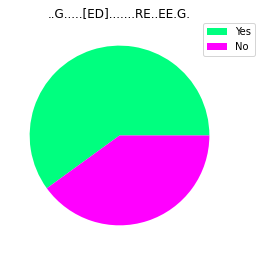

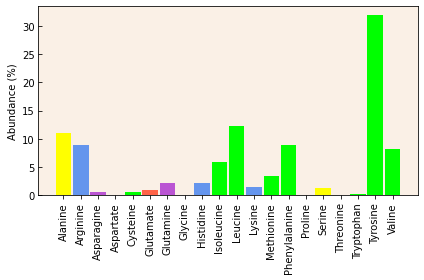

In [9]:
onlycanonical, protein_dataframe, onlynoncanonical = prepareFASTAfile(input("Enter the location of the fasta file with the protein sequences to assess:"))
savepath = input("Enter the filepath to the folder you want the figures saved in:")
canonicalNudixchart(protein_dataframe, savepath)
Nudix_box_dataframe = Nudixposition(onlycanonical, savepath)

In [12]:
Nudix_box_dataframe.loc[Nudix_box_dataframe['Position15'] == 'S']

,ID,Name,taxID,Nudix_Box,Position15,Sequence
675,Q52K88,"Nudix hydrolase 13, mitochondrial",3702,PKGGWEDDETVLEAASREAMEEAGV,S,MSNLSARTGRDHQRYDNNFRLVSGCIPYRLVKDEEEDSTSVDFENKLQVLMISSPNRHDLVFPKGGWEDDETVLEAASREAMEEAGVKGILREDPLGVWEFRSKSSSVEADCCLGGGCKGYMFALEVKEELAIWPEQDDRERRWLNVKEALELCRYEWMQSALEEFLRVMAEEGSTKEDSLAISSISNRGERQIDPRYCFVV
859,Q91FB1,Putative hydrolase 414L,176652,PKGKKESNETLLECASREVVEESGI,S,MKVLKKFIYNYKLINLLKMNKIKCAKGCCILNFTNEIHHFKNKNISKNSHRESAGIAIIVDENMDKKILITQSYNNLWGVPKGKKESNETLLECASREVVEESGIKVDVSSLKSCEEIIFIPNYDKKLTIHIFKYFIPFVDYISCSMNNLCLKDLHDDSTGFGWINLKCLNEITKAKTIKLNSLTKYILRKI
865,Q93ZY7,"Nudix hydrolase 12, mitochondrial",3702,PKGGWEDDETVLEAASREAIEEAGV,S,MSVLSSRTGRDRQRYDNNFRLVSGCIPYRLMKADETEEDSGVDFVNKLEVLMVSSPNRHDLVFPKGGWEDDETVLEAASREAIEEAGVKGILRELPLGVWEFRSKSSTVEDECLGGCKGYMFALKVTEELEDWPERKNRERRWLTVKEALELCRYEWMQRALEEFLRVMEDERRLRTEEETVHDSSKLEEESQIDPWYCFVVN
910,Q9LQU5,"Nudix hydrolase 18, mitochondrial",3702,PKGGWELDESVEEAASRESLEEAGV,S,MVCLVSRTGRQSQRYNKGRRQVVGCIPYRLKISSDGTISDEFEVLVISSQKGHALMFPKGGWELDESVEEAASRESLEEAGVVGNVERQLGKWDFLSKSKGTFYEGFMFPMLVKEELELWPEQHLRQRIWMKVDEARDACRDWWMKEALDVLVQRLSLLSLKPMEEDENLPLISIY
941,Q9ZU95,"Nudix hydrolase 17, mitochondrial",3702,PKGGWELDESVEEAASRECLEEAGV,S,MGVEKMVCLASRTGRQFQRYNKGRRQVVGCVPYRFKLSNDGKISDEVEVLVISSQKGHALMFPKGGWELDESVEEAASRECLEEAGVLGNVEHQLGKWDFLSKSRGTYYEGLMFPMLVTEQLELWPEQHVRQRIWMNVTEAREACRDWWMKEALDVLVERLSSPMNQPKEEKTMSISIETMC
